This notebook trained and tested the Neural Network. Due to the long training time, this takes approximately 20 minutes for running. Change the spark config for better runtime.

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

spark = (
    SparkSession.builder.appName("TrainingMLP")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')  
    .config('spark.executor.memory', '8g') 
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 15:08:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
file_path = '../data/curated/*'
df = spark.read.parquet(file_path)
df = df.sample(withReplacement=False, fraction=0.7, seed=42)
df.show(10)

+------------+-----------+--------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+----------+
|pulocationid|pu_location|pu_month|pu_day|pu_hour|is_weekend|is_peak_hour|trip_duration_minutes_scaled|trip_distance|fare_amount_scaled|wind_speed_scaled|dew_point_scaled|atmospheric_pressure_scaled|temperature_scaled|tip_amount|
+------------+-----------+--------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+----------+
|         114|  Manhattan|      12|     1|      0|         1|           0|                     -0.1192|          2.2|           -0.3928|           1.5346|         -1.3043|                     0.4759|           -0.8899|       3.0|
|         229|  Manhattan|      12|     1|      0|         1|           0|      

Creating the target column for training, using quantiles to classify tips into three categories: Small, moderate and large tips


In [3]:
df = df.withColumn(
    "tip_to_dist_ratio",
    F.col("tip_amount") / F.col("trip_distance")
)

# Calculating quantiles
percentiles = df.approxQuantile("tip_to_dist_ratio", [0.25, 0.75], 0.01)
Q1 = percentiles[0]
Q3 = percentiles[1]
print(Q1)
print(Q3)

df = df.withColumn(
    "tip_bin",
   F.when(F.col("tip_to_dist_ratio") <= Q1, 0)  #Small Tip
    .when(F.col("tip_to_dist_ratio") <= Q3, 1)   #Moderate Tip
    .otherwise(2) #Large Tip
)

# Describing number of instances in each classes
bin_counts = df.groupBy("tip_bin").agg(F.count("*").alias("count"))
total_count = df.count()
bin_percentages = bin_counts.withColumn("percentage", F.col("count") / F.lit(total_count) * 100)
bin_percentages.show()

1.132216014897579
2.4791666666666665
+-------+-------+------------------+
|tip_bin|  count|        percentage|
+-------+-------+------------------+
|      1|4611889|  49.5704986953036|
|      2|2371081|25.485363506571634|
|      0|2320727|24.944137798124764|
+-------+-------+------------------+



In [4]:
training_data = df.filter(df["pu_month"].isin([7,8,9,10,11]))
test_data = df.filter(df["pu_month"].isin([12]))
training_data.count()

7683553

In [5]:
feature_columns = [
    'pulocationid',"pu_day", "pu_hour", "is_weekend", "is_peak_hour",
    "trip_duration_minutes_scaled", "trip_distance", "fare_amount_scaled",
    "wind_speed_scaled", "dew_point_scaled", "atmospheric_pressure_scaled",
    "temperature_scaled"
]
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

In [6]:
test_data = test_data.select(*feature_columns,"tip_bin")
test_data.show(5)


+------------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+-------+
|pulocationid|pu_day|pu_hour|is_weekend|is_peak_hour|trip_duration_minutes_scaled|trip_distance|fare_amount_scaled|wind_speed_scaled|dew_point_scaled|atmospheric_pressure_scaled|temperature_scaled|tip_bin|
+------------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+-------+
|         114|     1|      0|         1|           0|                     -0.1192|          2.2|           -0.3928|           1.5346|         -1.3043|                     0.4759|           -0.8899|      1|
|         229|     1|      0|         1|           0|                      -0.286|          2.2|           -0.5194|           1.5346|         -1.3043|                     0.475

The follwing section perform training for the Neural Network.

In [7]:
layers = [len(feature_columns),32,64,16,3]

# Define the hyperparameters for the Neural Network
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="tip_bin",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=1234
)

# Fit the model to training data
pipeline = Pipeline(stages=[assembler, mlp])
model = pipeline.fit(training_data)


24/08/25 15:08:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/08/25 15:08:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/25 15:08:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Evaluate!

In [8]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="tip_bin",
    predictionCol="prediction",
    metricName="weightedRecall"
)

test_predictions = model.transform(test_data)

# Evaluate the test data
recall_score = evaluator.evaluate(test_predictions)
print(f"Recall score: {recall_score}")

Recall score: 0.6262468027533354


In [9]:
confusion_matrix = test_predictions.groupBy("tip_bin", "prediction").count()

# Show the confusion matrix
confusion_matrix.show()

+-------+----------+------+
|tip_bin|prediction| count|
+-------+----------+------+
|      2|       1.0|201443|
|      1|       0.0|104377|
|      0|       2.0| 27802|
|      0|       0.0|163249|
|      1|       2.0| 95132|
|      2|       2.0|262936|
|      1|       1.0|588425|
|      2|       0.0|  1298|
|      0|       1.0|175482|
+-------+----------+------+



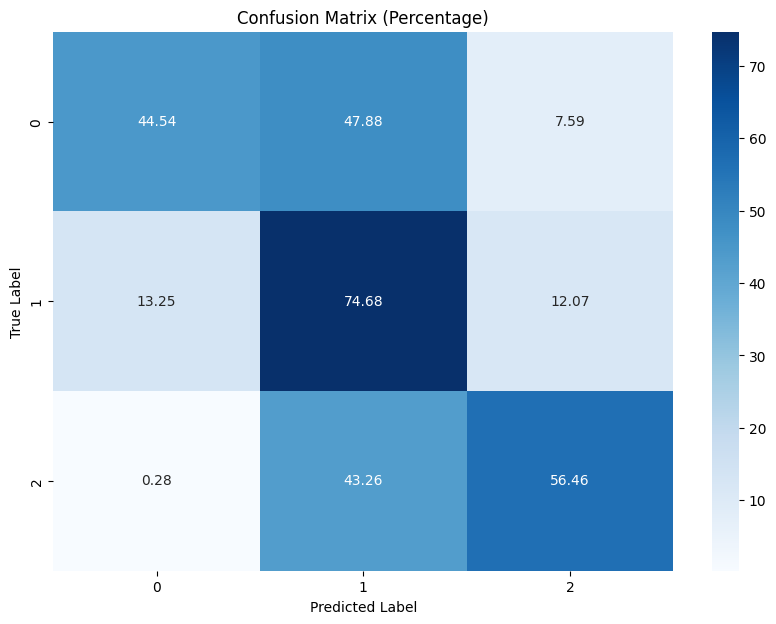

In [10]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the prediction column to integer
predictions = test_predictions.withColumn("prediction", F.col("prediction").cast("integer"))

# Create the confusion matrix
confusion_matrix = predictions.groupBy("tip_bin", "prediction").count()

# Compute total counts for each tip_bin
total_counts_per_tip_bin = confusion_matrix.groupBy("tip_bin").agg(F.sum("count").alias("total_count"))

# Join the total counts with the confusion matrix
confusion_matrix_with_totals = confusion_matrix.join(total_counts_per_tip_bin, on="tip_bin")

# Calculate percentages
confusion_matrix_percent = confusion_matrix_with_totals.withColumn(
    "percentage",
    (F.col("count") / F.col("total_count")) * 100
)

# Collect the results to a Pandas DataFrame for visualization
confusion_matrix_pd = confusion_matrix_percent.toPandas()

# Reshape the confusion matrix for heatmap
confusion_matrix_matrix = confusion_matrix_pd.pivot(
    index='tip_bin', columns='prediction', values='percentage'
).fillna(0)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')

plt.savefig("../plots/confusion_matrix_MLP.png", format="png")



In [12]:
model_path = "../MLP_trained"
model.save(model_path)